<h1>Nintendo Wii remote controlled Graphical User Interface (GUI) for CrazyFlie Drone</h1> <br>
AE483: Autonomous Systems, Fall 2021<br>
Erika Jarosch, George Petrov, Justin Roskamp, Kenneth Tochihara

Import Modules:

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d

# 1. Code Development

`gui.py` allows for the abstractions of the Crazyflie client controller. The group created flight controller buttons to connect to the specified radio channel, clear drawing pad, run flight, and abort flight if necessary. The drawing pad created by this file allows the user to draw out a specified path, which then becomes normalized given the size of the flight arena and send to the drone as move commands.

`client.py` allows for the actual control of the Crazyflie drone. The group derived the client from the lab in the class and applied it within the user interface. The client handles the flight paths and runs them according to the translated drawing that was received from the GUI. The class defined in this file is instantiated in the GUI.

`main.py` integrates the two files to simplify the execution of the code for the application. 

`controller_ae483.c` is the custom controller developed in lab. This was flashed onto the drone prior and was used to test different controller and observer configurations. 

# 2. Run the Application

To open the application, run the following commands in teh root directory of this repository according to your operating system. 

*__To run the application, a Wii remote is not required and can be operated with a mouse!__*

### MacOS

Make the script executable (one time)
```
chmod +x run_macos.sh
```

Run the script in Terminal
```
./run_macos.sh
```

### Windows

To start, run the commands in Anaconda Prompt
```
conda activate ae483
run_win.bat
```


Once the application is loaded, connect the Wii remote to you computer. Further instructions on installation can be found [here](https://linustechtips.com/topic/588687-how-to-use-your-wiimote-and-nunchuck-as-a-mouse/).

# 3. Usage and Save Data

## Running the Flight
1. Draw one continuous line as the desired flight path
2. Enter desired channel and flight zone area width
3. Click "Connect"
4. Click "Run Flight"
5. If any issues come up mid-flight, press the "Abort" button

## Saving the Data
Once the flight is complete and was not aborted, the program will generate a folder in `data` that contains the screenshot of GUI and the flight data. The folder will be timestamped according to the data and time of completetion of the flight.

The following cell contains a code snippet that details how the flight data is saved into the same directory. This can be found in the `gui.py` file. The `hardware_data.json` file can then be loaded and parsed through in the following section.

```
# save flight data to directory
directory_name = "data/" + time.strftime("%Y%m%d-%H%M%S")
os.mkdir(directory_name)
os.replace("src/hardware_data.json", directory_name + "/hardware_data.json")
im = ImageGrab.grab()
im.save(directory_name + '/gui.png')

```

# 4. Flight Data Results

Load flight test data with the function below.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=True):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # remove data entries that were used for the GUI
    data.pop("start_time")
    data.pop("end_time")
    
    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

## 4.1 Default Controller, Default Observer

Our first flight conducted was with a default controller and default observer. Below is the video taken for this flight.

<video controls src="data/20211212-165749-default-ctrl-default-obsv/flight_video.mov"/>

Below is the GUI screen captured after the flight was completed. 

 <img src="data/20211212-165749-default-ctrl-default-obsv/gui_cropped.png" width=480/>

Load and parse the data from the flight using the function defined above.

In [3]:
data = load_hardware_data(
    'data/20211212-165749-default-ctrl-default-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)

# time
t = data['time']

# desired position (inputs)
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# state estimate from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']

Plot the flight data according to the data recorded y the specific configuration and compare it with the desired location. For this case, since the desired location is not recorded throguh the custom controller firmware, the data for the desired location was not plotted.

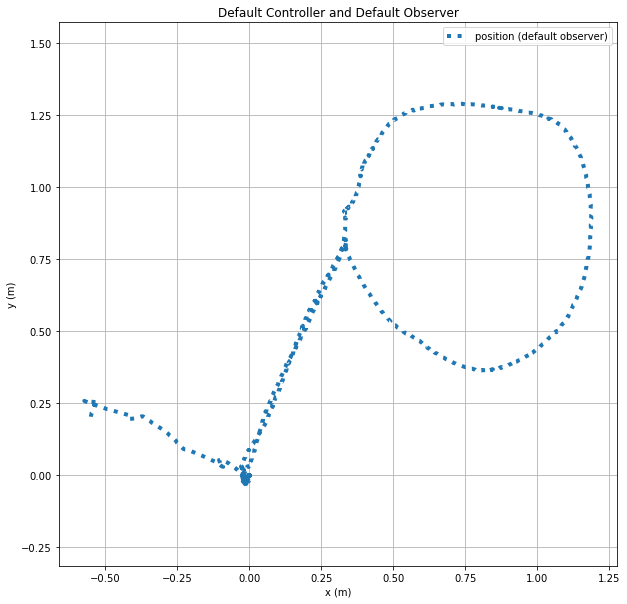

In [4]:
plt.figure(figsize=(10, 10))
plt.title("Default Controller and Default Observer")
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.grid()
plt.show()

## 4.2 Custom Controller, Custom Observer

Our second flight conducted was with a custom controller and custom observer. Below is the video taken for this flight.

<video controls src="data/20211212-172705-custom-ctrl-custom-obsv/flight_video.mov"/>

Below is the GUI screen captured after the flight was completed. 

 <img src="data/20211212-172705-custom-ctrl-custom-obsv/gui_cropped.png" width=480/>

Load and parse the data from the flight using the function defined above.

In [5]:
data = load_hardware_data(
    'data/20211212-172705-custom-ctrl-custom-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)

# time
t = data['time']

# desired position (inputs)
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# state estimate from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']

Plot the flight data according to the data recorded y the specific configuration and compare it with the desired location. Here we see three different lines, the desired location, the custom observed location, and the default observed location. 

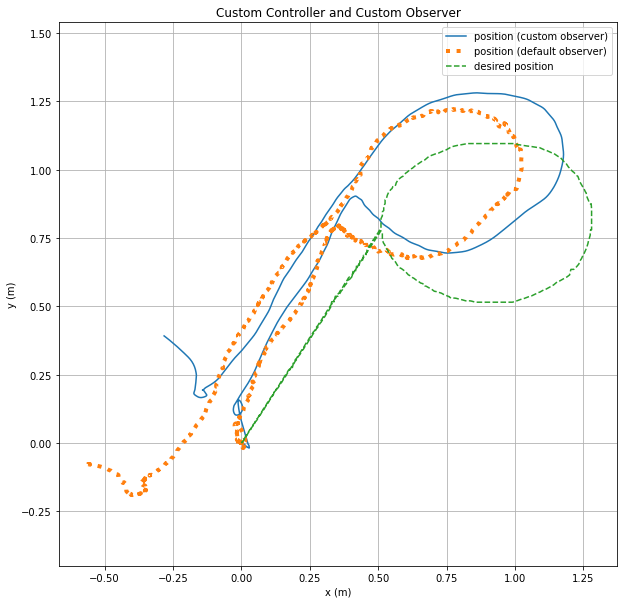

In [6]:
plt.figure(figsize=(10, 10))
plt.title("Custom Controller and Custom Observer")
plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.grid()
plt.show()

## 4.3 Custom Controller, Default Observer

Our third flight conducted was with a custom controller and default observer. Below is the video taken for this flight.

<video controls src="data/20211212-172835-custom-ctrl-default-obsv/flight_video.mov"/>

Below is the GUI screen captured after the flight was completed. 

 <img src="data/20211212-172835-custom-ctrl-default-obsv/gui_cropped.png" width=480/>

Load and parse the data from the flight using the function defined above.

In [7]:
data_default_default = load_hardware_data(
    'data/20211212-172835-custom-ctrl-default-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)

# time
t = data['time']

# desired position (inputs)
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# state estimate from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']

Plot the flight data according to the data recorded y the specific configuration and compare it with the desired location. Here we see two lines, the desired location and the default observed location. 

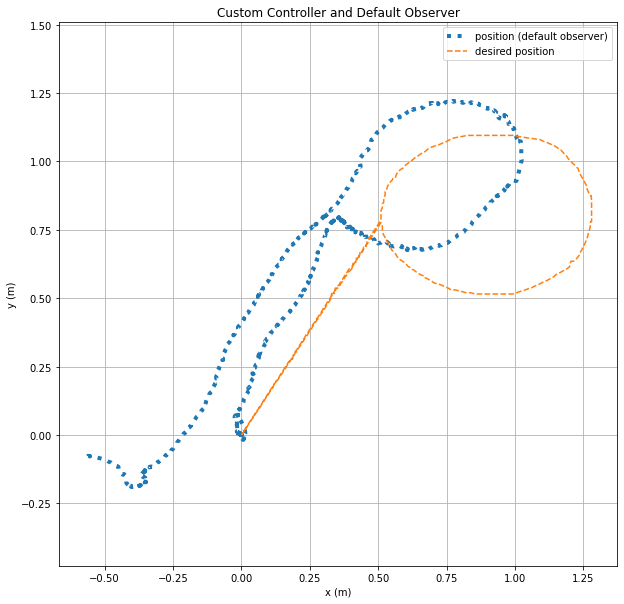

In [8]:
plt.figure(figsize=(10, 10))
plt.title("Custom Controller and Default Observer")
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.grid()
plt.show()

# 5. Summary

Three modes of flight were tested with this application. Some combinations of controller and observers were more success than others in terms of accuracy of the flight. Though for this project, the success was mostly focused on the ability for any user to replicate the set-up at home with a Crazyflie drone. For general use and accuracy, the default controller and default observer worked best and the group would recommend using that configuration until a more accurate custom controller and observer can be developed. Further improvements can be made by implementing the modern controller in order to reduce the on-board computational power. This would open the drone to further applications, and overall increase the systems functionality. 